# Regularization

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import (sigmoid, relu, plot_decision_boundary, initialize_parameters, 
                       load_2D_dataset, predict_dec, compute_cost, predict, 
                       forward_propagation, backward_propagation, update_parameters)

import sklearn.datasets  # For generating datasets
import scipy.io  # For handling .mat file formats (if needed)
from testCases import *  # Assuming test cases are for verification

# Configure inline plotting for Jupyter notebooks
%matplotlib inline

# Set default plot size
plt.rcParams['figure.figsize'] = (7.0, 4.0)

# Set default image interpolation method
plt.rcParams['image.interpolation'] = 'nearest'

# Set default color map for images
plt.rcParams['image.cmap'] = 'gray'


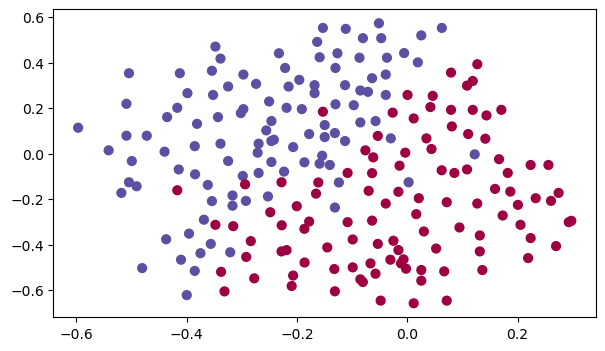

In [4]:
# Load the 2D dataset
train_X, train_Y, test_X, test_Y = load_2D_dataset()

# `train_X`: Training feature matrix (2D data, shape: (2, num_samples))
# `train_Y`: Training labels (shape: (1, num_samples))
# `test_X`: Test feature matrix (2D data, shape: (2, num_samples))
# `test_Y`: Test labels (shape: (1, num_samples))


## 1 - Non-regularized model

In [6]:
import matplotlib.pyplot as plt

def model(X, Y, learning_rate=0.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1):
    """
    Implements a three-layer neural network: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.

    Arguments:
    X -- Input data, of shape (input size, number of examples)
    Y -- True "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- Learning rate of the optimization
    num_iterations -- Number of iterations of the optimization loop
    print_cost -- If True, prints the cost every 10000 iterations
    lambd -- Regularization hyperparameter, scalar
    keep_prob -- Probability of keeping a neuron active during dropout, scalar
    
    Returns:
    parameters -- Parameters learned by the model, can be used for prediction
    """
    
    costs = []  # To keep track of the cost
    m = X.shape[1]  # Number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    
    for i in range(num_iterations):
        # Forward propagation
        if keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        else:
            a3, cache = forward_propagation(X, parameters)
        
        # Compute cost
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        # Backward propagation
        if lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        else:
            grads = backward_propagation(X, Y, cache)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print cost every 10000 iterations
        if print_cost and i % 10000 == 0:
            print(f"Cost after iteration {i}: {cost}")
        
        # Record cost for plotting
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # Plot the cost
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations (x1,000)')
    plt.title(f"Learning rate = {learning_rate}")
    plt.show()
    
    return parameters


Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724216
Cost after iteration 20000: 0.13851642423254343


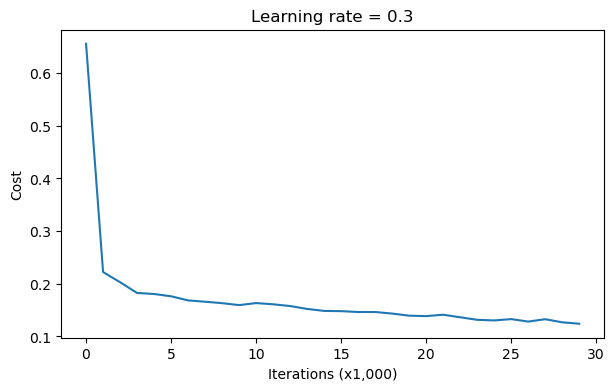

Evaluating performance on the training set:
Accuracy: 0.9478672985781991
Evaluating performance on the test set:
Accuracy: 0.915


In [7]:
# Train the model with training data (X and Y)
parameters = model(train_X, train_Y)

# Evaluate the model's performance on the training set
print("Evaluating performance on the training set:")
predictions_train = predict(train_X, train_Y, parameters)  # Predictions for training set

# Evaluate the model's performance on the test set
print("Evaluating performance on the test set:")
predictions_test = predict(test_X, test_Y, parameters)  # Predictions for test set


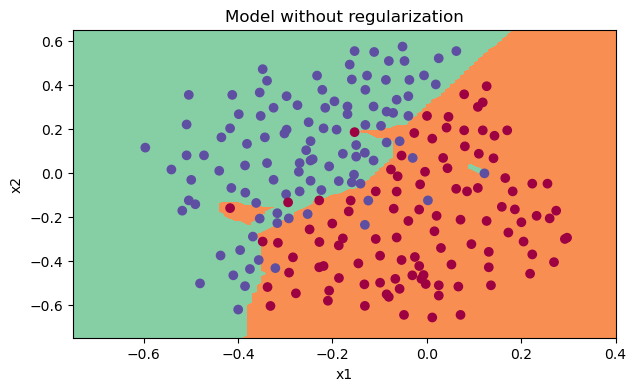

In [8]:
# Set plot title
plt.title("Model without regularization")

# Set x and y axis limits for better visualization
plt.xlim([-0.75, 0.40])  # Set x-axis limits
plt.ylim([-0.75, 0.65])  # Set y-axis limits

# Plot decision boundary for the model using the trained parameters
# predict_dec is a function that applies the trained model to predict values for input 'x'
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


## 2 - L2 Regularization

In [10]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Computes the cost with L2 regularization.
    
    Arguments:
    A3 -- Output from the final layer after forward propagation (shape: (output size, number of examples))
    Y -- True label vector (shape: (output size, number of examples))
    parameters -- Dictionary containing the weights of the neural network (W1, W2, W3)
    lambd -- Regularization hyperparameter, scalar
    
    Returns:
    cost -- Regularized cost (cross-entropy + L2 regularization term)
    """
    
    # Number of examples
    m = Y.shape[1]

    # Retrieve weights from the parameters dictionary
    W1, W2, W3 = parameters["W1"], parameters["W2"], parameters["W3"]

    # Compute the cross-entropy part of the cost (non-regularized)
    cross_entropy_cost = compute_cost(A3, Y)

    # Compute L2 regularization cost (summing up the squared weights of all layers)
    L2_regularization_cost = (lambd / (2 * m)) * (
        np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))
    )

    # Total cost (cross-entropy + L2 regularization)
    cost = cross_entropy_cost + L2_regularization_cost

    return cost


In [11]:
# Test case for computing cost with regularization
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

# Compute and print the regularized cost
# lambd is set to 0.1 for L2 regularization
cost = compute_cost_with_regularization(A3, Y_assess, parameters, lambd=0.1)
print(f"Cost with regularization: {cost}")


Cost with regularization: 1.7864859451590758


In [12]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation with L2 regularization for a three-layer neural network.
    
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- true "label" vector of shape (output size, number of examples)
    cache -- tuple containing intermediate values from forward propagation (Z, A, W, b for each layer)
    lambd -- L2 regularization hyperparameter, scalar
    
    Returns:
    gradients -- Dictionary containing gradients for weights (dW), biases (db), and activations (dZ, dA)
    """

    m = X.shape[1]  # Number of examples
    
    # Unpack cache values from forward propagation
    Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 = cache
    
    # Calculate gradients for the output layer
    dZ3 = A3 - Y
    dW3 = (1. / m) * np.dot(dZ3, A2.T) + (lambd / m) * W3  # Add L2 regularization term for W3
    db3 = (1. / m) * np.sum(dZ3, axis=1, keepdims=True)
    
    # Backpropagate to the second layer
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * (A2 > 0)  # ReLU derivative for Z2
    dW2 = (1. / m) * np.dot(dZ2, A1.T) + (lambd / m) * W2  # Add L2 regularization term for W2
    db2 = (1. / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # Backpropagate to the first layer
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (A1 > 0)  # ReLU derivative for Z1
    dW1 = (1. / m) * np.dot(dZ1, X.T) + (lambd / m) * W1  # Add L2 regularization term for W1
    db1 = (1. / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    # Store all gradients in a dictionary
    # gradients = {
    #     "dZ3": dZ3, "dW3": dW3, "db3": db3,
    #     "dZ2": dZ2, "dW2": dW2, "db2": db2,
    #     "dZ1": dZ1, "dW1": dW1, "db1": db1
    # }
    gradients = {
        "dZ3": dZ3, "dW3": dW3, "db3": db3,
        "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
        "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1
    }
    
    return gradients


In [13]:
# Test case setup for backward propagation with regularization
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

# Perform backward propagation with L2 regularization
# lambd is the regularization parameter to control the degree of regularization (set to 0.7)
grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd=0.7)

# Output the calculated gradients for weight matrices W1, W2, and W3
print(f"dW1 = \n{grads['dW1']}")  # Gradient of the first layer's weights
print(f"dW2 = \n{grads['dW2']}")  # Gradient of the second layer's weights
print(f"dW3 = \n{grads['dW3']}")  # Gradient of the third layer's weights


dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


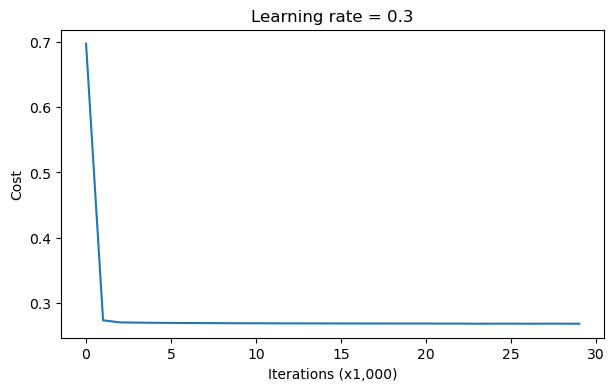

On the training set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [14]:
# Train the model with L2 regularization (lambda = 0.7)
# train_X and train_Y are the input data and labels respectively
parameters = model(train_X, train_Y, lambd=0.7)

# Evaluate the model's performance on the training set
print("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)

# Evaluate the model's performance on the test set
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)


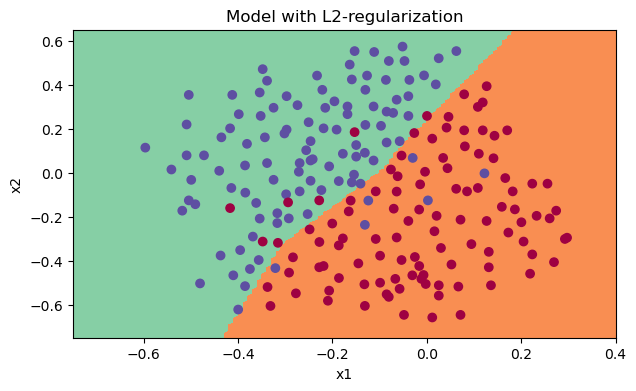

In [15]:
# Set plot title
plt.title("Model with L2-regularization")

# Set axis limits for better visualization
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])

# Plot the decision boundary for the model using the learned parameters
# 'x.T' is used to ensure correct dimensionality for predictions
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


## 3 - Dropout

### 3.1 - Forward propagation with dropout

In [18]:
import numpy as np

# Implements forward propagation with dropout
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    """
    Forward propagation with dropout regularization: 
    (LINEAR -> RELU + DROPOUT) -> (LINEAR -> RELU + DROPOUT) -> (LINEAR -> SIGMOID).
    
    Arguments:
    X -- input data, shape (input features or 2, number of examples)
    parameters -- dictionary containing model weights and biases (W1, b1, W2, b2, W3, b3)
    keep_prob -- dropout probability, scalar (default 0.5)
    
    Returns:
    A3 -- output of final activation (sigmoid), shape (1, number of examples)
    cache -- values needed for backpropagation (intermediate activations, dropout masks, etc.)
    """
    
    np.random.seed(1)  # Ensure reproducibility
    
    # Retrieve parameters
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]
    
    # Layer 1: LINEAR -> RELU -> DROPOUT
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(*A1.shape) < keep_prob  # Create dropout mask based on keep_prob
    A1 *= D1  # Apply dropout mask to shut down some neurons
    A1 /= keep_prob  # Scale activations to account for dropout during trainin
    
    # Layer 2: LINEAR -> RELU -> DROPOUT
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(*A2.shape) < keep_prob  # Dropout mask
    A2 *= D2  # Apply dropout
    A2 /= keep_prob  # Scale by keep_prob
    
    # Layer 3: LINEAR -> SIGMOID
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    # Store intermediate values needed for backpropagation
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache


In [19]:
# Test case: Forward propagation with dropout
X_assess, parameters = forward_propagation_with_dropout_test_case()

# Perform forward propagation with dropout
A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob=0.7)

# Output the final activation value A3
print(f"A3 = {A3}")


A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


## 3.2 - Backward propagation with dropout

In [21]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of the model with dropout regularization.
    
    Arguments:
    X -- input dataset, of shape (input_size or 2, number of examples)
    Y -- true "labels" vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout (contains intermediate values)
    keep_prob -- probability of keeping a neuron active during dropout, scalar
    
    Returns:
    gradients -- Dictionary containing gradients with respect to parameters, activations, and pre-activation variables.
    """
    
    # Number of training examples
    m = X.shape[1]

    # Unpack cache from forward propagation
    Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3 = cache

    # Compute gradients for the output layer (Layer 3)
    dZ3 = A3 - Y  # Gradient of the cost with respect to Z3
    dW3 = (1. / m) * np.dot(dZ3, A2.T)  # Gradient of W3
    db3 = (1. / m) * np.sum(dZ3, axis=1, keepdims=True)  # Gradient of b3
    dA2 = np.dot(W3.T, dZ3)  # Gradient of A2 (needed for next layer's backprop)

    # Dropout on second hidden layer (Layer 2)
    dA2 *= D2  # Apply dropout mask from forward propagation (same neurons are shut down)
    dA2 /= keep_prob  # Scale the surviving neurons by keep_prob

    # Backprop for the second hidden layer (Layer 2)
    dZ2 = dA2 * (A2 > 0)  # Gradient of Z2 using ReLU's derivative (only pass when A2 > 0)
    dW2 = (1. / m) * np.dot(dZ2, A1.T)  # Gradient of W2
    db2 = (1. / m) * np.sum(dZ2, axis=1, keepdims=True)  # Gradient of b2
    dA1 = np.dot(W2.T, dZ2)  # Gradient of A1 (needed for Layer 1 backprop)

    # Dropout on first hidden layer (Layer 1)
    dA1 *= D1  # Apply dropout mask from forward propagation
    dA1 /= keep_prob  # Scale the surviving neurons

    # Backprop for the first hidden layer (Layer 1)
    dZ1 = dA1 * (A1 > 0)  # Gradient of Z1 using ReLU's derivative
    dW1 = (1. / m) * np.dot(dZ1, X.T)  # Gradient of W1
    db1 = (1. / m) * np.sum(dZ1, axis=1, keepdims=True)  # Gradient of b1

    # Store all gradients in a dictionary
    gradients = {
        "dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
        "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1,
        "dZ1": dZ1, "dW1": dW1, "db1": db1
    }

    return gradients


In [22]:
# Test case for backward propagation with dropout
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

# Perform backward propagation with dropout
gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob=0.8)

# Print relevant gradient values for inspection
print(f"dA1 = \n{gradients['dA1']}")
print(f"dA2 = \n{gradients['dA2']}")


dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0: 0.6543912405149825


/home/muhammad-saqib/DL Project for github/Untitled Folder 4/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/muhammad-saqib/DL Project for github/Untitled Folder 4/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.061016986574905605
Cost after iteration 20000: 0.060582435798513114


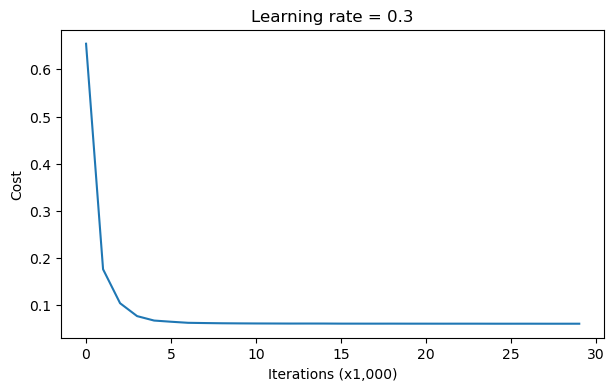

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [41]:
# Train the model with dropout regularization and specific learning rate
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3)

# Predict on the train set
print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)

# Predict on the test set
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)


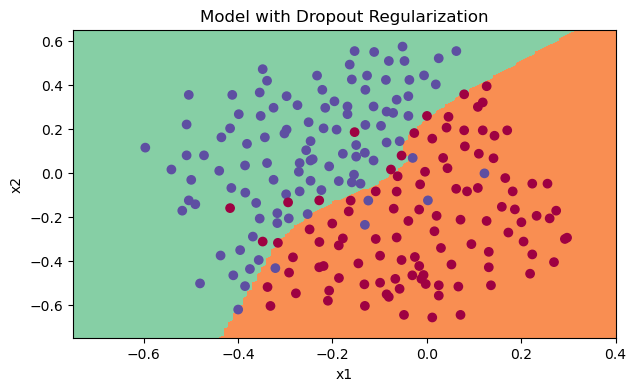

In [45]:
# Set plot title
plt.title("Model with Dropout Regularization")

# Set axis limits for better visualization of the decision boundary
plt.xlim([-0.75, 0.40])  # X-axis limit
plt.ylim([-0.75, 0.65])  # Y-axis limit

# Plot the decision boundary using the model's parameters and training data
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


## 4 - Conclusions

<h3>Results of the Three Models:</h3>
<table>
    <tr>
        <th>Model</th>
        <th>Train Accuracy</th>
        <th>Test Accuracy</th>
    </tr>
    <tr>
        <td>3-layer NN without regularization</td>
        <td>95%</td>
        <td>91.5%</td>
    </tr>
    <tr>
        <td>3-layer NN with L2-regularization</td>
        <td>94%</td>
        <td>93%</td>
    </tr>
    <tr>
        <td>3-layer NN with dropout</td>
        <td>93%</td>
        <td>95%</td>
    </tr>
</table>
